#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

#### Импорт датасета

In [2]:
df = pd.read_csv("mushroom.csv")

In [3]:
df.describe()

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


#### Предварительная обработка данных

В колонке `stalk-root` есть пропущенные значения. Посчитаем процент пропущенных значений

In [4]:
len(df.loc[df['stalk-root'] == "?"]) / len(df) * 100

30.526834071885773

Удалим колонку из-за высокого процента пропущенных значений

In [5]:
df = df.drop(columns='stalk-root')

#### Создание дерева

In [6]:
class Node():
    def __init__(self, feature_index=None, feature_value=None, gainratio=None, value=None, is_root_node=False):
        
        # for decision node
        self.feature_index = feature_index
        self.feature_value = feature_value
        self.children = []
        self.gainratio = gainratio
        self.is_root_node = is_root_node
        
        # for leaf node
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None
    
    def create_child(self, child):
        return self.children.append(child)

    def fit(self, X_test):
        pred = pd.Series()
        for i, row in X_test.iterrows():
            pred[i] = self._fit_row(row)
        return pred
    
    def _fit_row(self, X_test_row, parent=None):
        if parent is None: parent = self
        children = parent.children
        try:
            if children[0].is_leaf_node():
                return children[0].value
        except:
            pass
        for child in children:
            if X_test_row[child.feature_index] == child.feature_value:
                return self._fit_row(X_test_row, parent=child)
        else:
            return np.NaN

    
    def print_tree(self, depth=0):
        if self.is_root_node:
            print("Root")
        elif self.is_leaf_node():
            print(depth * "  " + f"poisonous = {self.value}")
        else:
            print(depth * "  " + f"{self.feature_index} = {self.feature_value}")

        if self.children:
            depth += 1
            for child in self.children:
                child.print_tree(depth)

#### Формулы с расчётом значений и созданием дерева решений

In [7]:
# Split info + энтропия (если не вписывать атрибут column)
def get_split_info(df, column="poisonous"):
	info = 0
	column_values = df[column].value_counts(normalize=True)
	for value in column_values:
		info -= value * np.log2(value)
	return info

In [8]:
def get_infox(df, column):
	column_values = df[column].value_counts(normalize=True)
	infox = 0
	for value, p in column_values.items():
		infox += p * get_split_info(df.loc[df[column] == value])
	return infox

In [9]:
def get_gainratio(df, column):
	if get_split_info(df, column) == 0: return 1
	return (get_split_info(df) - get_infox(df, column)) / get_split_info(df, column)

In [10]:
def get_column_with_max_gainratio(df):
	feature_index, max_gainratio = None, 0
	for column in df:
		if column == "poisonous": continue
		gainratio = get_gainratio(df, column)
		if max_gainratio <= gainratio:
			feature_index = column
			max_gainratio = gainratio
	return feature_index, max_gainratio

In [11]:
def build_tree(df, parent=None):
	root = Node(is_root_node=True)
	if not parent:
		parent = root
	feature_index, max_gainratio = get_column_with_max_gainratio(df)
	if max_gainratio == 0:
		child = Node(value=list(set(df.poisonous))[0])
		parent.children.append(child)
	else:
		for feature_value in set(df[feature_index]):
			child = Node(feature_index=feature_index, feature_value=feature_value, gainratio=max_gainratio)
			
			split_info = get_split_info(df)
			if split_info == 0:
				child = Node(value=list(set(df.poisonous))[0])
			else:
				next_df = df.loc[df[feature_index] == feature_value].drop(columns=[feature_index])
				build_tree(next_df, parent=child)
			parent.children.append(child)
		if not parent.children:
			child = Node(value=list(set(df.poisonous))[0])
			parent.children.append(child)
	return root

#### Рандомный выбор колонок из датасета

In [12]:
import random
from math import ceil, sqrt

columns = list(df.drop(columns=["poisonous"]).columns)
number_of_columns = ceil(sqrt(len(list(df.columns))))
picked_columns = random.sample(columns, number_of_columns)

df = df[picked_columns].join(df.poisonous)

print("Выбранные колонки")
for i, el in enumerate(picked_columns):
	print(f"  {i + 1}. {el}")

Выбранные колонки
  1. stalk-color-above-ring
  2. gill-color
  3. ring-type
  4. population
  5. ring-number


#### Построение дерева и предсказание на тестовой выборке

In [13]:
from sklearn.model_selection import train_test_split

# for random_state in range(50):
df_train, df_test = train_test_split(df, test_size=0.3)
X_test, Y_test = df_test.drop(columns=["poisonous"]), df_test.poisonous
tree = build_tree(df_train)
tree.print_tree()
pred = tree.fit(X_test)

Root
  ring-type = l
    poisonous = p
  ring-type = f
    poisonous = e
  ring-type = n
    poisonous = p
  ring-type = p
    stalk-color-above-ring = g
      poisonous = e
    stalk-color-above-ring = n
      poisonous = e
    stalk-color-above-ring = p
      poisonous = e
    stalk-color-above-ring = o
      poisonous = e
    stalk-color-above-ring = w
      population = y
        poisonous = e
      population = c
        poisonous = p
      population = s
        ring-number = t
          poisonous = e
        ring-number = o
          gill-color = g
            poisonous = e
          gill-color = h
            poisonous = p
          gill-color = n
            poisonous = e
          gill-color = p
            poisonous = e
          gill-color = u
            poisonous = p
          gill-color = k
            poisonous = e
          gill-color = w
            poisonous = e
      population = n
        poisonous = e
      population = v
        ring-number = t
          gill-col

#### Преобразование тестовых откликов и результатов предсказания из строковых значений в бинарные

In [14]:
for index, value in Y_test.items():
	Y_test[index], pred[index] = 1 if value == "e" else 0, 1 if pred[index] == "e" else 0

#### Оценка предсказаний

In [15]:
def get_confusion_matrix(Y_test, pred):
	confusion_matrix = np.zeros((2, 2), dtype=int)
	for index, value in Y_test.items():
		confusion_matrix[value - 1][pred[index] - 1] += 1
	return confusion_matrix

def print_statistics(Y_test, pred):
	confusion_matrix = get_confusion_matrix(Y_test, pred)
	TN, FP, FN, TP = confusion_matrix.ravel()
	print("Матрица ошибок:")
	for el in confusion_matrix:
		print(f"  {el}")
	print("\nОценки:")
	print("  Accuracy:", (TP + TN) / (TP + TN + FP + FN))
	print("  Precision:", TP / (TP + FP))
	print("  Recall:", TP / (TP + FN))

In [16]:
print_statistics(Y_test, pred)

Матрица ошибок:
  [1237    0]
  [214 987]

Оценки:
  Accuracy: 0.9122231337161608
  Precision: 1.0
  Recall: 0.8218151540383014


#### AUC-ROC и AUC-PR кривая

In [20]:
def calculate_roc_curve(y_true, pred):
    df = pd.DataFrame({'y_true': y_true, 'pred': pred})
    df = df.sort_values(by='pred', ascending=False)

    tpr_list, fpr_list = [], []
    total_positive = sum(y_true)
    total_negative = len(y_true) - total_positive

    for threshold in [i / 100 for i in range(0, 101, 5)]:
        predicted_positive = df['y_true'][df['pred'] >= threshold].sum()
        tpr = predicted_positive / total_positive
        fpr = (df['y_true'][df['pred'] >= threshold] == 0).sum() / total_negative
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    fpr_list.append(0)
    tpr_list.append(0)

    return fpr_list, tpr_list

fpr, tpr = calculate_roc_curve(Y_test, pred)

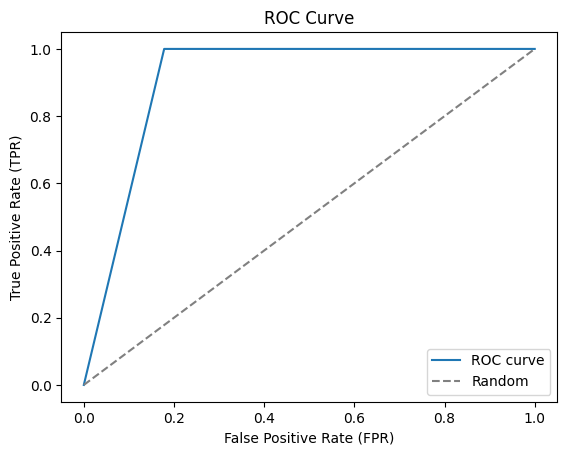

In [21]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [20]:
def calculate_precision_recall_curve(y_true, pred):

    df = pd.DataFrame({'y_true': y_true, 'pred': pred})
    df = df.sort_values(by='pred', ascending=False)
    y_true_sorted = df["y_true"]
    
    true_positives, false_positives, false_negatives = 0, 0, 0
    precision_values = []
    recall_values = []

    for _, el in y_true_sorted.items():
        if el == 1:
            true_positives += 1
        else:
            false_positives += 1
        false_negatives = np.sum(y_true_sorted == 1) - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

        precision_values.append(precision)
        recall_values.append(recall)

    return np.array(precision_values), np.array(recall_values)

precision, recall = calculate_precision_recall_curve(Y_test, pred)

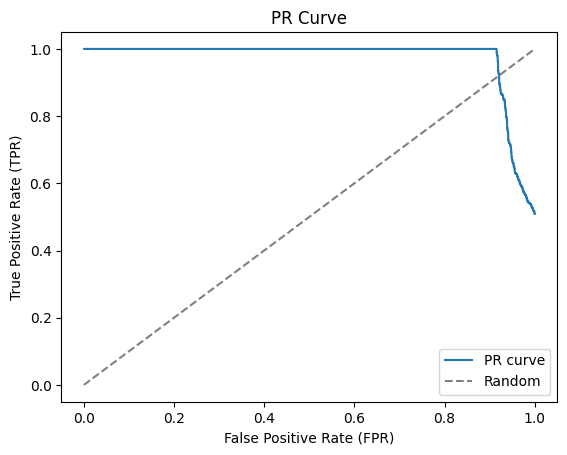

In [21]:
plt.plot(recall, precision, label='PR curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('PR Curve')
plt.legend()
plt.show()